In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import gzip
import pickle
from itertools import product
from nuplan.planning.training.modeling.closed_loop_utilities.target_trajectory_recomputer import TargetTrajectoryRecomputer
import torch
import random

In [6]:
dataset_path = "/mnt/nas20/zhuangzhuang.ding/nuplan/nuplan_cache_mini_horizon_raster_v1.1"
sample_db_path = os.path.join(dataset_path, '2021.06.09.17.37.09_veh-12_00404_00864')

In [7]:
traj_zips = glob.glob(os.path.join(sample_db_path, "**/trajectory.gz"), recursive=True)

In [8]:
high_mag = [i for i in traj_zips if "high_magnitude_speed" in i]
right_turn = [i for i in traj_zips if "starting_right_turn" in i]

In [9]:
def np_matrix_from_pose(pose: np.ndarray) -> np.ndarray:
    """Generate numpy pose matrices from pose array.

    Args:
        pose (np.ndarray): Nx3 array. The first 3 number in each row represents
            x, y, heading.

    Returns:
        np.ndarray: Nx3x3 matrices.
    """
    t, _ = pose.shape
    x = pose[..., 0]
    y = pose[..., 1]
    h = pose[..., 2]
    row1 = np.stack([np.cos(h), -np.sin(h), x], axis=-1)
    row2 = np.stack([np.sin(h), np.cos(h), y], axis=-1)
    row3 = np.array([[0.0, 0.0, 1.0]]).repeat(t, axis=0)
    matrix = np.stack([row1, row2, row3], axis=1)
    return matrix

In [10]:
rot_angle = np.pi/2
rot_mat = np.array([
    [np.cos(rot_angle), -np.sin(rot_angle), 0.],
    [np.sin(rot_angle), np.cos(rot_angle), 0.],
    [0., 0., 1.]
])

In [11]:
smoother = TargetTrajectoryRecomputer(16, 0.5)

In [33]:
def big_draw_func(gt_traj):
    plt.figure(figsize=(16, 12))
    
    gt_pose_mats = np_matrix_from_pose(gt_traj)
    gt_canvas_mats = rot_mat[None, ...] @ gt_pose_mats

    # Generate relative positions as matrices
    x_shift = [0, 1.5]
    y_shift = [-1.5, 1.5]
    ang_shift = [np.pi/6, 0, -np.pi/6]
    combination = []
    for x, y, ang in product(x_shift, y_shift, ang_shift):
        combination.append([x, y, ang])
    combination = np.array(combination)

    rel_matrices = np_matrix_from_pose(combination) # A series of closed loop starting points

    gt_speed = np.linalg.norm(np.diff(gt_traj[:, :2], axis=0), axis=1)[0] / 0.5
    print(gt_speed)
    # rel_matrices = np_matrix_from_pose(np.array([[0.0, 0.0, 0.0]]))

    for i, rel_matrix in enumerate(rel_matrices):
        plt.subplot(3, 4, i+1)
        solve_success, new_target = smoother.recompute(torch.from_numpy(gt_traj), torch.from_numpy(rel_matrix), gt_speed)
        assert solve_success is True
        new_matrices = np_matrix_from_pose(new_target.numpy())
        traj_wrt_zero = rot_mat[None, ...] @ rel_matrix @ new_matrices

        # Plot closed loop starting point
        canvas_rel_mat = rot_mat @ rel_matrix
        plt.plot(canvas_rel_mat[0, 2], canvas_rel_mat[1, 2], 'ro')

        plt.plot(0., 0., 'bo') # Gt starting point, aka ego-car
        # Draw gt trajectory and direction
        x = gt_canvas_mats[:, 0, 2]
        y = gt_canvas_mats[:, 1, 2]
        plt.plot(x, y, 'o')
        for mat in gt_canvas_mats:
            x = mat[0, 2]
            y = mat[1, 2]
            sin = mat[1, 0]
            cos = mat[0, 0]
            plt.arrow(x, y, cos*3, sin*3, head_length=0.7, head_width=0.02)

        # Draw optimized trajectory and direction
        x = traj_wrt_zero[:, 0, 2]
        y = traj_wrt_zero[:, 1, 2]
        plt.plot(x, y, 'o')
        for mat in traj_wrt_zero:
            x = mat[0, 2]
            y = mat[1, 2]
            sin = mat[1, 0]
            cos = mat[0, 0]
            plt.arrow(x, y, cos*3, sin*3, head_length=0.7, head_width=0.02)

        h = np.arctan2(rel_matrix[1, 0], rel_matrix[0, 0]) * 180 / np.pi
        plt.title(f"x:{rel_matrix[0, 2]:.2f} | y:{rel_matrix[1,2]:.2f} | h:{h:.2f}")
        plt.grid('minor')
        plt.axis('equal')
        # plt.xlim([-10., 10.])
        # plt.ylim([-2., 18.])
        # break
        

11.06718921661377


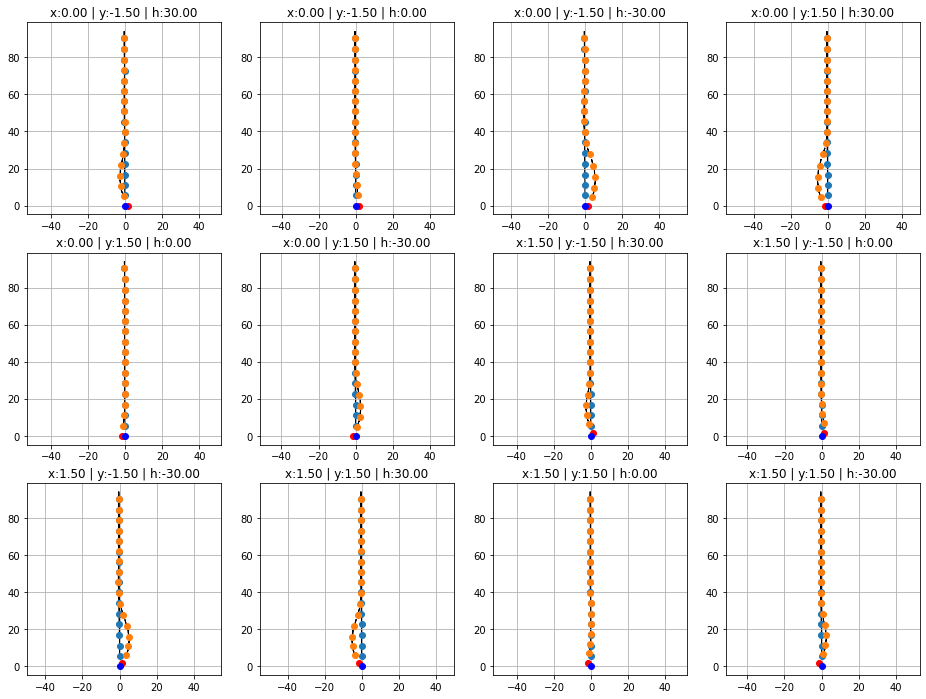

In [34]:
with gzip.open(high_mag[30], 'rb') as f:
    gt = pickle.load(f)['data']
big_draw_func(gt)

2.5264556


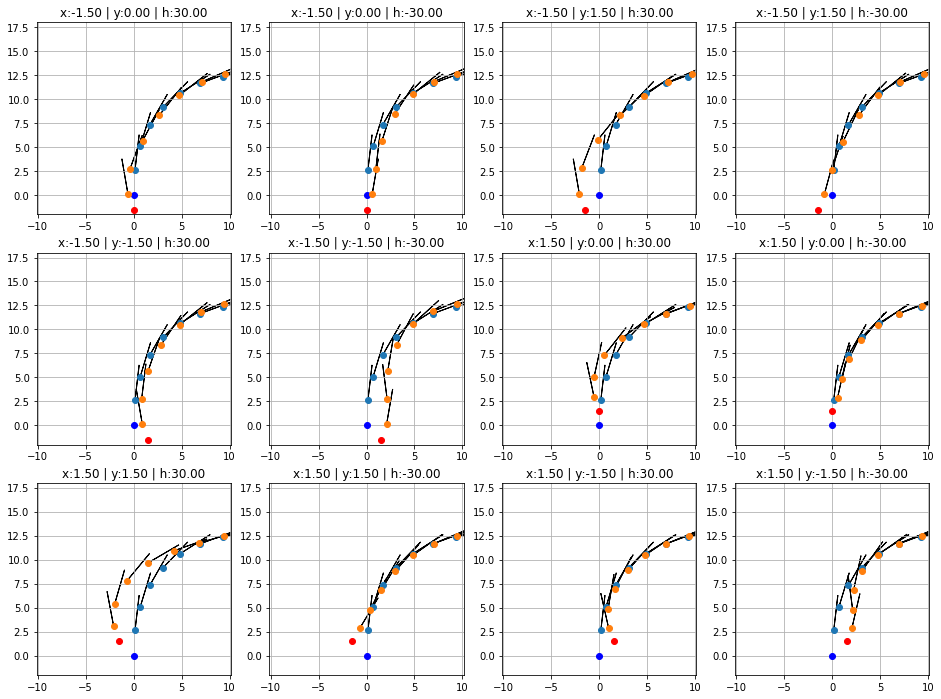

In [23]:
with gzip.open(right_turn[0], 'rb') as f:
    gt = pickle.load(f)['data']
big_draw_func(gt)